# What is xG? 

Today I want to create a comprehensive guide to building an xG model. While I believe that you could follow along with a very basic knowledge of football and analytics, I will offer some sources at the bottom for those that would like a review or just want to dive deeper. Before we get into the data analysis, it is important to define what xG is and consider why we may be interested in creating an xG model.  

For those of you more familiar with English football culture, you may have heard the term 'smash and grab' thrown around to describe a match in which a team absorbed a great deal pressure (normally in the form of shots on their goal) for the majority of the game but managed to steal a good result. This sort of performance is normally met with praise from pundits and fans alike for the team's character, resilence and work-ethic. This sort of soft factor analysis may put what was actually a poor performance and a lucky result in an undeserving good light. 

Football is full of random and unpredictable factors that influence results. A good result may just be a consequence of random factors that are heavily weighted in favor of one of the teams. This is important to consider because if we were to rely on result data (specifically goals for and goals against) to analyze the performance of team, we would not be accounting for these random factors. Take a look at the highlights from when the Manchester United visited Arsenal in the Premier League 2017/2018


https://www.youtube.com/watch?v=HfYGrrYAQD0

We can see from the highlight package that Arsenal clearly created more shooting oppurtunities and a quick look at the stat sheet would show that Arsenal amassed 33 shots to Manchester United's lowly 8. But does this translate to a better Arsenal performance and were they unlucky to lose? Were a majority of Arsenal's shots low quality (i.e. from a poor angles or a long distance out)? Although Manchester United produced only 8 shots, were they from more dangerous positions? How can we quantify these metrics? 



It is these sort of questions that the expected goal (xG) metric tries to answer. Traditional football analysis is often subjected and deeply flawed but in creating a quantitative analysis tool like the xG model, we can cut through opinion based analysis with something more factual. 

xG measures the probabilty that a shot will result in a goal. Over the course of a match or season it is a measure of shot quality and quanity that a team creates. It therefore can serve as a guage on how potent a team is in attack and how solid they are on the back. It can also be used to analyze a players ability to create shooting oppurtunities in dangerous areas and how well he takes his chances. In summary, the xG model helps us eliminate a majority of the random factors associated with scoring oppurtunites when we attempt to quantify a team's ability to score goals, which in the end is the ultimate goal of football.

We will see later that we can use xG to predict future results, guide decisions on player recruitment and evaulate coaching instructions but we will get into that later. 

# Data Exploration

Before we get into building our xG model, we need to consider what sort of data we are interested in. Obviously, we need a large collection of shot data but importantly we need the data to describe the type of shots that result in goals. This should include the distance from goal when the shot was taken, the angle with respect to the goal and what part of the body the shot was taken with. We can infer that these variables have the greatest impact on the probability of a shot resulting in a goal. To reinforce this, let's do some data exploration.

Football data is normally split into two forms: event data and tracking data. Event data records all on-ball events and where on the pitch they happened (such as shots, passes, tackles, dribbles) whereas tracking data records the positions of players and the ball through-out the game at regular intervals. I will be using tracking data in future posts but for today's purposes we are going to be using event data.





The event data that I will use today will come from Wyscout. It covers all events from all matches across the top 5 domestics leagues in Europe (English Premier League, Ligue 1, Bundesliga, La Liga, Seria a) from the 2017/2018 season.


Most of the work we are going to do is going to be based on the hypothesis that the probability of a shot is dependent on the distance from which the shot was taken to the goal as well as the angle made with the goal line. We will also consider how headers impact the proabability. 

Now Let's get into it. 

In [616]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

**Data Extraction and Wrangling**

First we have to import all the files that contain our event data. We will also import our libraries in the cell below.

In [617]:
#import pandas and numpy for data wrangling and manipulation
import pandas as pd
import numpy as np
import os
import json
import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
#we need to load in our json files (where our event data is stored)
#https://figshare.com/collections/Soccer_match_event_dataset/4415000/2
#I will be using the os library to create a list of the json files from my directory 
directory = '/Users/Ian/Desktop/IDanalytics/xG_model/events'
jsonfiles = []
for path in os.listdir(directory):
    jsonfiles.append(os.path.join(directory,path))
print(jsonfiles)

['/Users/Ian/Desktop/IDanalytics/xG_model/events/events_France.json', '/Users/Ian/Desktop/IDanalytics/xG_model/events/events_Spain.json', '/Users/Ian/Desktop/IDanalytics/xG_model/events/events_Germany.json', '/Users/Ian/Desktop/IDanalytics/xG_model/events/events_Italy.json', '/Users/Ian/Desktop/IDanalytics/xG_model/events/events_England.json']


Now we are going to parse through the json files and extract all the relevent shot data to store in a tiddy seperate dataframe. Most of this will be done using the pandas and numpy library. 

In [618]:
def shot_matrix(eventdata):
    with open(eventdata) as f:
        data = json.load(f)
    
    #lets create the dataframe that we want to store our data in and all the attributes we are interested in 
    shots_dataset = pd.DataFrame(columns=['Goal','x','y','playerid','teamid','matchid','header'])
    
    #remember that the jsonfiles include passes, shots, tackles etc so we need to filter through these
    #lets find all the occurences of a shot within the set
    #refer to link in the prevous cell for info on the Wyscout event dataset, including tag names
    event_df = pd.DataFrame(data)
    all_shots = event_df[event_df['subEventName']=='Shot']
    
    #now we need to fill in our shots_dataset matrix by attribute columns
    #we will do this by filtering through the all-shot df (dataframe) we just made
    for index,shot in all_shots.iterrows():
        #here we fill in the columns for goals and headers with binary descripters
        shots_dataset.at[index,'Goal']=0
        shots_dataset.at[index,'header']=0
        for tag in shot['tags']:
            if tag['id']==101:
                shots_dataset.at[index,'Goal']=1
            elif tag['id']==403:
                shots_dataset.at[index,'header']=1
                
        #now we are interested in distance from the goal as well as the angle formed with the goal
        #Wyscouts pitch has its origin at the top left of the pitch and is 100m x 100m
        #therefore x and y represent percentage of nearness to top left corner 
        #most pitches are 105 meters by 68 so we will go with that
        shots_dataset.at[index,'Y']=shot['positions'][0]['y']*.68
        shots_dataset.at[index,'X']= (100 - shot['positions'][0]['x'])*1.05
        
        #now we use dummy variables x and y to calc distance and angle attributes
        shots_dataset.at[index,'x']= 100 - shot['positions'][0]['x'] 
        shots_dataset.at[index,'y']=shot['positions'][0]['y']
        shots_dataset.at[index,'Center_dis']=abs(shot['positions'][0]['y']-50)
        
        x = shots_dataset.at[index,'x']*1.05
        y = shots_dataset.at[index,'Center_dis']*.68
        shots_dataset.at[index,'Distance'] = np.sqrt(x**2 + y**2)
        
        #we are interested in the angle made between the width of the goal and the
        #straight line distance to the shot location. A goal is 7.32 meters wide
        #use the law of cosines
        c=7.32
        a=np.sqrt((y-7.32/2)**2 + x**2)
        b=np.sqrt((y+7.32/2)**2 + x**2)
        k = (c**2-a**2-b**2)/(-2*a*b)
        gamma = np.arccos(k)
        if gamma<0:
            gamma = np.pi + gamma
        shots_dataset.at[index,'Angle Radians'] = gamma
        shots_dataset.at[index,'Angle Degrees'] = gamma*180/np.pi
        
        #lastly we add the identifiers for player, team and match
        shots_dataset.at[index,'playerid']=shot['playerId']
        shots_dataset.at[index,'matchid']=shot['matchId']
        shots_dataset.at[index,'teamid']=shot['teamId']
        
        
    return shots_dataset
    

In [619]:
all_leagues = []
for file in jsonfiles:
    all_leagues.append(shot_matrix(file))
df = pd.concat(all_leagues)

/Users/Ian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in arccos


**Data Cleaning**

Now, before we get into exploring the dataset we just created, we should do some data cleaning. It it normal, especially with such a large collection of data, that there could have been some values inputed incorrectly, some values missing or just situations that we did not anticipate for. For example, we should check to see why we are encountering an error in arccos. 

In [620]:
#find out if the error is producing nan values
df.isnull().values.any()

True

In [621]:
#find how many such nan values
df.isnull().sum().sum()

6

In [622]:
df[df.isnull().any(axis=1)]

,Goal,x,y,playerid,teamid,matchid,header,Y,X,Center_dis,Distance,Angle Radians,Angle Degrees
417224,1,0,49,4131,698,2565801,0,33.32,0.0,1.0,0.68,NaN,NaN
365140,1,0,52,224971,2445,2516954,0,35.36,0.0,2.0,1.36,NaN,NaN
499325,1,0,57,206314,3161,2576251,0,38.76,0.0,7.0,4.76,NaN,NaN


So it seems that there were some goals scored from the touch line which would require us to rethink how we created our construction of the angle attribute. Since there were only 3 occurences of such events and since they are normally unintentional rare events, I will remove them from our model. This is mainly to keep things simple.  

In [623]:
df.dropna()

,Goal,x,y,playerid,teamid,matchid,header,Y,X,Center_dis,Distance,Angle Radians,Angle Degrees
213,1,6,57,256992,3799,2500686,0,38.76,6.30,7.0,7.896050,0.755576,43.291300
302,0,17,42,334552,3772,2500686,1,28.56,17.85,8.0,18.660549,0.372069,21.317963
498,1,4,43,26389,3772,2500686,0,29.24,4.20,7.0,6.348039,0.851948,48.813019
577,0,16,21,276920,3772,2500686,0,14.28,16.80,29.0,25.905953,0.184838,10.590449
629,0,27,51,366760,3799,2500686,0,34.68,28.35,1.0,28.358154,0.256637,14.704224
...,...,...,...,...,...,...,...,...,...,...,...,...,...
642945,0,28,45,8561,1633,2500098,0,30.60,29.40,5.0,29.595946,0.244517,14.009788
643023,1,14,33,41174,1633,2500098,0,22.44,14.70,17.0,18.700898,0.309646,17.741433
643051,0,12,62,7879,1623,2500098,0,42.16,12.60,12.0,15.011516,0.410444,23.516712
643055,0,8,38,145692,1623,2500098,0,25.84,8.40,12.0,11.710918,0.461143,26.421528


Now it seems we have some unnecessary columns that stored dummy variables when we computed distance and angles. Let's remove them.

In [715]:
df.drop(columns = ['x','y','Center_dis'])

,Goal,playerid,teamid,matchid,header,Y,X,Distance,Angle Radians,Angle Degrees,Distance_Bins
213,1,256992,3799,2500686,0,38.76,6.30,7.896050,0.755576,43.291300,"(6.873, 8.644]"
302,0,334552,3772,2500686,1,28.56,17.85,18.660549,0.372069,21.317963,"(18.31, 19.755]"
498,1,26389,3772,2500686,0,29.24,4.20,6.348039,0.851948,48.813019,"(0.679, 6.873]"
577,0,276920,3772,2500686,0,14.28,16.80,25.905953,0.184838,10.590449,"(24.897, 26.285]"
629,0,366760,3799,2500686,0,34.68,28.35,28.358154,0.256637,14.704224,"(27.894, 29.647]"
...,...,...,...,...,...,...,...,...,...,...,...
642945,0,8561,1633,2500098,0,30.60,29.40,29.595946,0.244517,14.009788,"(27.894, 29.647]"
643023,1,41174,1633,2500098,0,22.44,14.70,18.700898,0.309646,17.741433,"(18.31, 19.755]"
643051,0,7879,1623,2500098,0,42.16,12.60,15.011516,0.410444,23.516712,"(14.968, 15.923]"
643055,0,145692,1623,2500098,0,25.84,8.40,11.710918,0.461143,26.421528,"(11.265, 12.249]"


Great! We now have a tiddy dataset of all the shots taken in the 2017/2018 season. Now let's see what sort of relationship there is between shot result and distance and angle. I think the best way to do this is to vizualize the data. 

**Data Visualization**

The best place to start is to see how shots are distributed by distance and angle. 

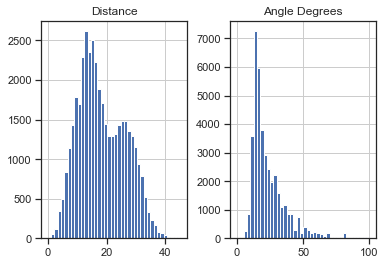

In [625]:
#plot distributions of shots by distance and angle side by side
fig, axes = plt.subplots(1, 2)
distance = df.hist("Distance",bins=40,range = (0,45),ax= axes[0])
angles = df.hist("Angle Degrees",bins=40, range = (0,100),ax=axes[1])

The distributions suggest that:
1. A majority of shots happen between 10 and 20 meters
2. Shots taken within about 6 meters are quite rare in comparision to shot taken outside 10 meters
3. Oddly enough, there is a trough of the amount shots taken between 18m to about 25m
4. As expected, players rarely take shots from angles less than 5 degrees
5. The angle distribution agrees with distance distribution in that shots taken from closer (larger angles) are much more difficult to produce

While we now know how shots are distributed by distance and angle, we have yet to explore how shots that result in goals differ from those that do not. Let's do this with some violin plots first. 

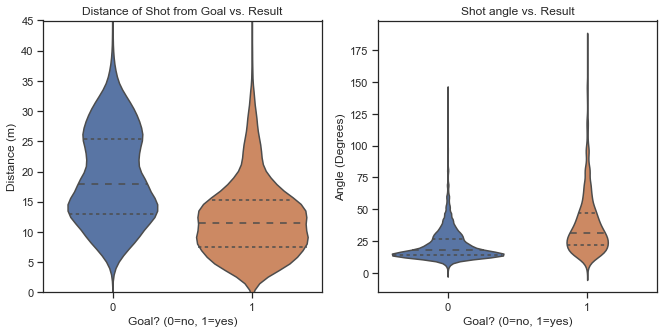

In [626]:
#use the seaborn library to inspect the distribution of the shots by result (goal or no goal) 
fig, axes = plt.subplots(1, 2,figsize=(11, 5))

#use seaborn lib for violin plot and extract necessary columns from our dataframe df
shot_dist = sns.violinplot(x="Goal", y="Distance",
                    data=df, inner="quart",ax= axes[0])
shot_dist.set(xlabel="Goal? (0=no, 1=yes)",
       ylabel="Distance (m)",
       title="Distance of Shot from Goal vs. Result",ylim=(0, 45));

#similar as before
shot_ang = sns.violinplot(x="Goal", y="Angle Degrees",
                    data=df, inner="quart",ax = axes[1])
shot_ang.set(xlabel="Goal? (0=no, 1=yes)",
       ylabel="Angle (Degrees)",
       title="Shot angle vs. Result");


The violin plot above plays a similar role to a box and whiskers plot but also provides use with the kernal distribution estimate of the data (essentially a smoothing of the distribution). In  splitting up the data by the result of the shot, we can see that on average, shots that result in goals are taken from much closer to goal than shots that do not result in goals. The mean of shots resulting in goals is about 12 meters compared to about 18 meters for those that don't bulge the net. 

Similarly, goals are typically scored from angles of 20 degrees to about 50 degrees.

Let's see how headers impact the mean and the distributions. 

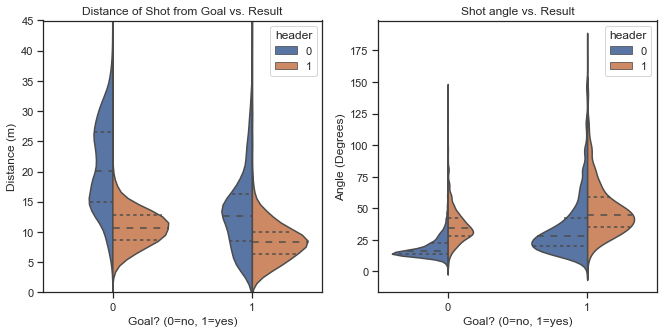

In [716]:
fig, axes = plt.subplots(1, 2,figsize=(11, 5))

shot_distance = sns.violinplot(x="Goal", y="Distance",hue='header',
                    data=df, inner="quart",split=True,ax = axes[0])
shot_distance.set(xlabel="Goal? (0=no, 1=yes)",
       ylabel="Distance (m)",
       title="Distance of Shot from Goal vs. Result",ylim=(0, 45));

shot_ang = sns.violinplot(x="Goal", y="Angle Degrees",hue='header',
                    data=df, inner="quart",split=True,ax = axes[1])
shot_ang.set(xlabel="Goal? (0=no, 1=yes)",
       ylabel="Angle (Degrees)",
       title="Shot angle vs. Result");

Headers, as we might expect, are normally taken within the 18 yard box (16.5 m). Interestly the means and distributions of the results do not differ by much, so that is something we should consider down the line.  

Lovely! We have used some data visulization to learn about what our data is saying such as how shots are distributed by distance and angle and how these variable impact the result. Yet, I think we can take this one step further!

We can better visualize how these variables impact the result by plotting the density of shots on a pitch. That is, we would like to split the pitch up into bins, calculate the number of shots taken within each bin and then use a color gradient to visualize how the density differs from bin to bin. Then we can do the same for goals and compare the results. There are many libraries and tools to do this, so feel free to explore what you like, but I prefer hexbin from the matplotlib library. 

First we need to draw a pitch. I won't go into how to do this as that is beyond the scope here. I used Peter McKeever's fantastic turtorial on how to draw pitches and suggest you check it out for yourself. I'll leave a link at the bottom. Let's get into it. 

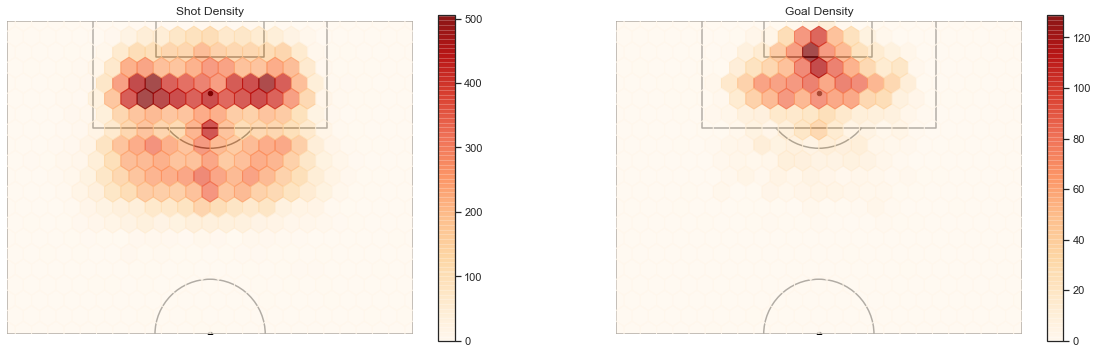

In [628]:
#import the pitch diagram
from PlotPitch import draw_pitch 

# Similar to the violin plot except we now plot all shots on the left and only goals on the right
fig, ax = plt.subplots(1,2,figsize=(20, 6))
plt.sca(ax[0])
draw_pitch(orientation="vertical",
           aspect="half",
           pitch_color='white',
           line_color="black",
           ax=ax[0])
df_shots = df[df['header']==0]
plt.hexbin(data =df_shots, x='Y', y='X',zorder=1,cmap='OrRd',gridsize=(25,10),alpha=.7,extent=(0,68,0,52))
ax[0].set_xlim(0, 68)
ax[0].set_ylim(52.5,0)
plt.colorbar()
plt.axis('off')
ax[0].set_title('Shot Density')

#now for the goals
plt.sca(ax[1])
#look at only shots that resulted in goals
df_goals = df[(df['Goal']==1) & (df['header']==0)]
draw_pitch(orientation="vertical",
           aspect="half",
           pitch_color='white',
           line_color="black",
           ax=ax[1])
plt.hexbin(data = df_goals,x='Y', y='X',zorder=1,cmap='OrRd',gridsize=(25,10),alpha=.7,extent=(0,68,0,52))
ax[1].set_xlim(0, 68)
ax[1].set_ylim(52.5,0)
plt.colorbar()
plt.axis('off')
ax[1].set_title('Goal Density')

plt.show()


These density plots serve a similar function to the violin plots above but give us a much better visual understanding of which areas of the pitch normally produce shots and goals. This is because we can see how both distance and angle impact the distribution of shots on the same plot. 

As we learned with the violin plots:
1. Shots are seldom taken from either side the box due to the poor angle 
2. A majority of the shots are taken around the penalty spot(11m)
3. There are quite a few shots taken just outside the box, up to about 30m
4. Goals are normally scored witin a 11m and within a narrow area

As you might guess, we can plot a probability density to evaluate which areas of the pitch have a high probability of a shot resulting in the goal and which do not.


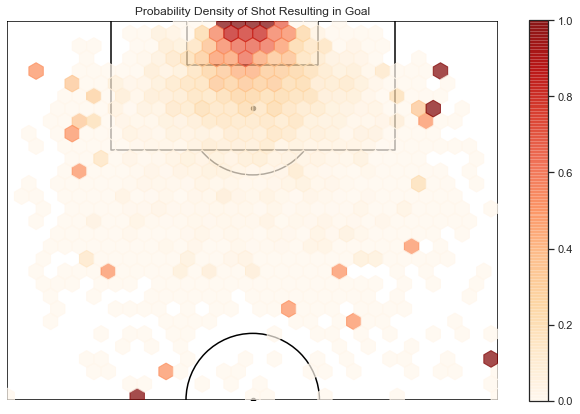

In [683]:
#probabilty density of shot resulting in goals
df_shots =df[df['header']==0]
prob=np.array(df_shots['Goal'])
fig, ax = plt.subplots(figsize=(11, 7))
draw_pitch(orientation="vertical",
           aspect="half",
           pitch_color='white',
           line_color="black",
           ax=ax)
plt.hexbin(data = df_shots,x='Y', y='X',C=prob,reduce_C_function=np.mean,cmap='OrRd',gridsize=(34,15),
           alpha=.7,extent=(0,68,0,52))
ax.set_xlim(0,68)
ax.set_ylim(52.5,0)
plt.colorbar()
plt.axis('off')
ax.set_title('Probability Density of Shot Resulting in Goal')

plt.show()

As expected, the closer you shoot from the goal, the more likely the shot is to result in a goal. Notice that there are certain outliers in which the probability density in those bin are very high. This is because of the few shots taken from those areas, they resulted in goals. If we had say 10 seasons of data, we would see a much more homogenous probabilty density. 

And what about headers?

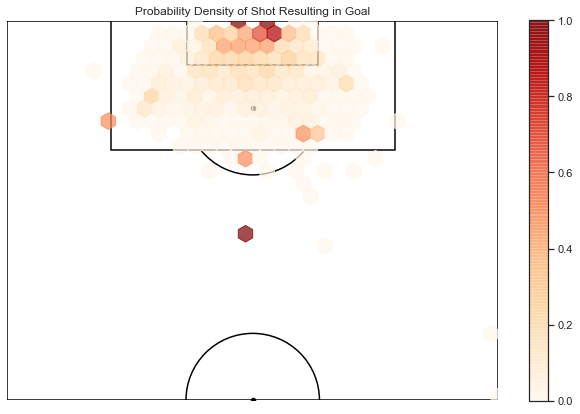

In [681]:
#probabilty density of headers resulting in goals 
df_header = df[df['header']==1]
prob=np.array(df_header['Goal'])

fig, ax = plt.subplots(figsize=(11, 7))
draw_pitch(orientation="vertical",
           aspect="half",
           pitch_color='white',
           line_color="black",
           ax=ax)
plt.hexbin(data = df_header,x='Y', y='X',C=prob,reduce_C_function=np.mean,cmap='OrRd',gridsize=(34,15),
           alpha=.7,extent=(0,68,0,52))
ax.set_xlim(0,68)
ax.set_ylim(52.5,0)
plt.colorbar()
plt.axis('off')
ax.set_title('Probability Density of Shot Resulting in Goal')

plt.show()

While headers exhibit a similar trend to regular shots, they have lower probability values overall. This seems to suggest that while headers happen closer to goal on average, they also represent a much more difficult chance to put away. As we will see down the line, this is an important discovery and one that impacts our interpretation of chance evaulation. 

Before we progress into some machine learning, I want to close with us trying to gain some insight into these trends.
We have hypothesized that both the distance and the angle with the goal line affect the probability of a shot resulting in a goal and we have seen that with the graphs above. But what is the nature of this relationship? As we move away from the goal, how does the probability of scoring change? We can address these question as we have done before, with some well designed graphs. 

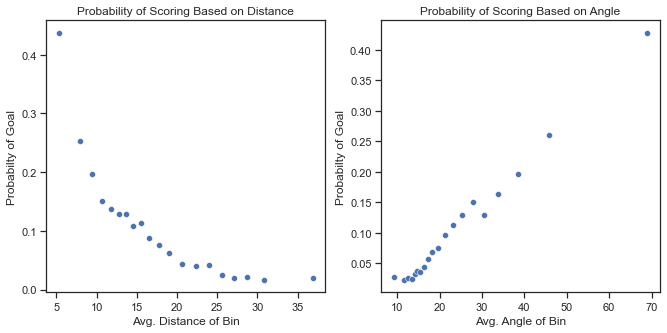

In [767]:
#use the seaborn library to inspect the distribution of the shots by result (goal or no goal) 
fig, axes = plt.subplots(1, 2,figsize=(11, 5))
#first we want to create bins to calc our probability
#pandas has a function qcut that evenly distibutes the data 
#into n bins based on a desired column value
df['Goal']=df['Goal'].astype(int)
df['Distance_Bins'] = pd.qcut(df['Distance'],q=20)
#now we want to find the mean of the Goal column(our prob density) for each bin
#and the mean of the distance for each bin
dist_prob = df.groupby('Distance_Bins',as_index=False)['Goal'].mean()['Goal']
dist_mean = df.groupby('Distance_Bins',as_index=False)['Distance'].mean()['Distance']
dist_trend = sns.scatterplot(x=dist_mean,y=dist_prob,ax=axes[0])
dist_trend.set(xlabel="Avg. Distance of Bin",
       ylabel="Probabilty of Goal",
       title="Probability of Scoring Based on Distance")


df['Angle_Bins'] = pd.qcut(df['Angle Degrees'],q=20)
angle_prob = df.groupby('Angle_Bins',as_index=False)['Goal'].mean()['Goal']
angle_mean = df.groupby('Angle_Bins',as_index=False)['Angle Degrees'].mean()['Angle Degrees']
angle_trend = sns.scatterplot(x=angle_mean,y=angle_prob,ax=axes[1])
angle_trend.set(xlabel="Avg. Angle of Bin",
       ylabel="Probabilty of Goal",
       title="Probability of Scoring Based on Angle")


plt.show()

pitch dimensions:https://mplsoccer.readthedocs.io/en/latest/gallery/pitch_setup/plot_compare_pitches.html
